In [4]:
import config
import time

import pandas as pd
import matplotlib.pyplot as plt
import dataframe_image as dfi
import numpy as np

from neo4j import GraphDatabase

In [5]:
# set up connection
driver = GraphDatabase.driver(config.uri, auth=(config.user, config.password), encrypted=False)

# Check if connection did work
def check_connectivity(driver):
    try:
        with driver.session() as session:
            result = session.run("RETURN 1 as result")
            record = result.single()
            if record and record["result"] == 1:
                return True
            else:
                print('False')
                return False
    except Exception as e:
        return False


if check_connectivity(driver):
    print("Verbindung erfolgreich hergestellt.")
else:
    print("Fehler bei der Verbindungsherstellung.")

Verbindung erfolgreich hergestellt.


# Graph Database Algorithm

## Projection

In [6]:
def drop_projection() -> None:
    """
    Drop the projection of the graph.
    """
    with driver.session() as session:
        drop_projection_query = "CALL gds.graph.drop('gene_protein_graph')"
        
        session.run(drop_projection_query)
        print("Projection dropped.")

def create_projection() -> None:
    """
    Create a projection of the graph for the gene and protein nodes.
    """
    with driver.session() as session:
        projection_query = """
        CALL gds.graph.project(
            'gene_protein_graph',
            {
                gene: {
                    label: 'gene'
                },
                protein: {
                    label: 'protein'
                }
            },
            {
                interaction: {
                    type: 'interaction',
                    orientation: 'UNDIRECTED'
                },
                connection: {
                    type: 'connection',
                    orientation: 'UNDIRECTED'
                }
            }
        )
        """
        
        session.run(projection_query)
        print("Graph projection created.")

# drop_projection()
create_projection()

Graph projection created.


## Helper Functions

In [7]:
def drop_protein_nodes(df) -> pd.DataFrame:
    """
    Drop the protein nodes from the dataframe.
    :param df: The dataframe with the protein nodes.
    """
    return df[~df["Gene_ID"].str.contains("ENSP")]

## Pagerank

In [8]:
def run_pagerank() -> pd.DataFrame:
    """
    Pagerank algorithm performed on the genes.
    :return: 
    """
    with driver.session() as session:
        query = """
        CALL gds.pageRank.stream('gene_protein_graph')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).id AS Gene_ID,
               gds.util.asNode(nodeId).gene_name AS Gene_Name,
               score, 
               gds.util.asNode(nodeId).Δ_TPM AS Δ_TPM,
               gds.util.asNode(nodeId).Δ_TPM_relevant AS Δ_TPM_relevant
        ORDER BY score DESC
        """
    
        result = session.run(query)
        
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
        
        df_results["score"] = df_results["score"].round(3)
    
        return df_results

start = time.time()

df_pagerank = run_pagerank()

end = time.time()
print(f"Time taken: {round(end - start, 0)} seconds.")

Time taken: 13.0 seconds.


In [9]:
print("Only genes nodes:")
df_pagerank.head(100)

Only genes nodes:


,Gene_ID,Gene_Name,score,Δ_TPM,Δ_TPM_relevant
0,ENSG00000109339,MAPK10,67.209,-0.051677,False
1,ENSG00000115392,FANCL,40.200,0.149585,False
2,ENSG00000107862,GBF1,37.993,0.034794,False
3,ENSG00000145362,ANK2,36.668,-0.025229,False
4,ENSG00000121940,CLCC1,34.903,0.028258,False
...,...,...,...,...,...
101,ENSG00000103034,NDRG4,16.373,-0.128267,False
102,ENSG00000103811,CTSH,16.373,-0.056641,False
103,ENSG00000173230,GOLGB1,16.373,0.031236,False
104,ENSG00000146282,RARS2,16.373,0.079608,False


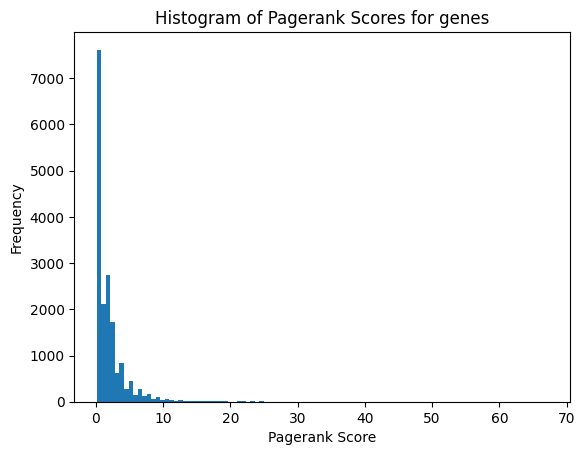

In [10]:
plt.hist(df_pagerank["score"], bins=100)
plt.xlabel("Pagerank Score")
plt.ylabel("Frequency")
plt.title("Histogram of Pagerank Scores for genes")

plt.savefig('../tex/figures/04_hist_pagerank.png')
plt.show()

### Relevant Genes

In [11]:
print("Only genes with cancer active nodes:")
df_pagerank_relevant = df_pagerank.where(df_pagerank["Δ_TPM_relevant"] == True).dropna()

# save the dataframe as an image
dfi.export(df_pagerank_relevant.reset_index(drop=True).head(10), '../tex/figures/03_03_df_pagerank_relevant.png')

df_pagerank_relevant.head(10)

Only genes with cancer active nodes:
generate html


,Gene_ID,Gene_Name,score,Δ_TPM,Δ_TPM_relevant
22,ENSG00000165795,NDRG2,25.635,-0.317776,True
57,ENSG00000161249,DMKN,19.901,-0.203997,True
76,ENSG00000092529,CAPN3,18.136,-0.310797,True
157,ENSG00000157103,SLC6A1,14.170,-0.267816,True
170,ENSG00000110436,SLC1A2,13.729,-0.233129,True
189,ENSG00000012048,BRCA1,13.289,0.214719,True
196,ENSG00000022267,FHL1,12.850,-0.217644,True
206,ENSG00000197971,MBP,12.849,-0.296146,True
284,ENSG00000049540,ELN,11.119,-0.246766,True
291,ENSG00000172995,ARPP21,11.090,-0.201848,True


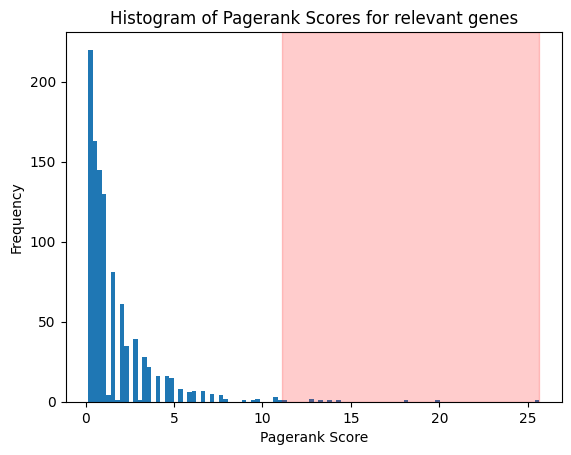

In [12]:
plt.hist(df_pagerank_relevant["score"], bins=100)
plt.xlabel("Pagerank Score")
plt.ylabel("Frequency")
plt.title("Histogram of Pagerank Scores for relevant genes")

# highlight the top 10 genes
min = df_pagerank_relevant["score"].head(10).min()
max = df_pagerank_relevant["score"].head(10).max()
plt.axvspan(min, max, color='r', alpha=0.2)

plt.savefig('../tex/figures/04_hist_pagerank_relevant.png')
plt.show()

In [13]:
# Statistics
mean_score = df_pagerank_relevant["score"].mean()
median_score = df_pagerank_relevant["score"].median()
percentiles = np.percentile(df_pagerank_relevant["score"], [25, 50, 75, 90, 95, 99])
max_score = df_pagerank_relevant["score"].max()

# Ergebnisse ausgeben
print(f"Mean of Pagerank Scores: {mean_score:.2f}")
print(f"Median of Pagerank Scores: {median_score:.2f}")
print(f"25th Percentile: {percentiles[0]:.2f}")
print(f"50th Percentile (Median): {percentiles[1]:.2f}")
print(f"75th Percentile: {percentiles[2]:.2f}")
print(f"90th Percentile: {percentiles[3]:.2f}")
print(f"95th Percentile: {percentiles[4]:.2f}")
print(f"99th Percentile: {percentiles[5]:.2f}")
print(f"Maximum Pagerank Score: {max_score:.2f}")

Mean of Pagerank Scores: 1.62
Median of Pagerank Scores: 0.78
25th Percentile: 0.44
50th Percentile (Median): 0.78
75th Percentile: 1.97
90th Percentile: 3.67
95th Percentile: 5.39
99th Percentile: 10.65
Maximum Pagerank Score: 25.64


In [14]:
# lowest Pagerank score - gene with a single protein
lowest = df_pagerank_relevant[df_pagerank_relevant["score"] == 0.151]
print(f"From the {df_pagerank_relevant.shape[0]} relevant genes, {lowest.shape[0]} have a minimum pagerank score of 0.151.")

lowest

From the 1033 relevant genes, 155 have a minimum pagerank score of 0.151.


,Gene_ID,Gene_Name,score,Δ_TPM,Δ_TPM_relevant
120280,ENSG00000118245,TNP1,0.151,-0.480377,True
120288,ENSG00000254726,MEX3A,0.151,0.300823,True
120309,ENSG00000186193,SAPCD2,0.151,0.263108,True
120310,ENSG00000186009,ATP4B,0.151,-0.244448,True
120318,ENSG00000148965,SAA4,0.151,-0.241782,True
...,...,...,...,...,...
121830,ENSG00000115008,IL1A,0.151,0.220975,True
121836,ENSG00000198830,HMGN2,0.151,0.219837,True
121841,ENSG00000101412,E2F1,0.151,0.278975,True
121846,ENSG00000254772,EEF1G,0.151,-0.647684,True


In [15]:
df_nodes_genes = pd.read_csv('../processed_data/nodes_genes.csv')
relevant_genes = df_nodes_genes[(df_nodes_genes['Δ TPM relevant'] == True)]

min_significant = relevant_genes[relevant_genes['Δ TPM'] < 0]['Δ TPM'].max()
max_significant = relevant_genes[relevant_genes['Δ TPM'] > 0]['Δ TPM'].min()
min_delta = df_nodes_genes['Δ TPM'].min()
max_delta = df_nodes_genes['Δ TPM'].max()

### Top 10 Genes

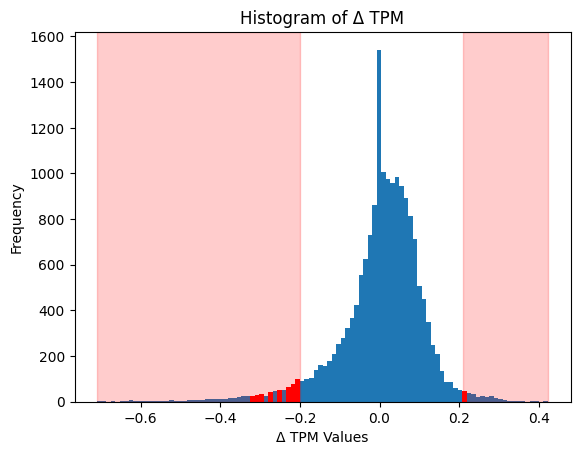

In [16]:
counts, bins, patches = plt.hist(df_nodes_genes['Δ TPM'], bins=100)
plt.title('Histogram of Δ TPM')
plt.xlabel('Δ TPM Values')
plt.ylabel('Frequency')

# highlight the relevant genes
plt.axvspan(min_delta, min_significant, color='r', alpha=0.2)
plt.axvspan(max_significant, max_delta, color='r', alpha=0.2)

# highlight the known genes
highlight_values = df_pagerank_relevant["Δ_TPM"].head(10)
for value in highlight_values:
    for i in range(len(bins) - 1):
        if bins[i] <= value < bins[i + 1]:
            patches[i].set_facecolor('red')


plt.savefig('../tex/figures/04_delta_tpm_relevant.png')
plt.show()

### Known Cancer Genes

In [17]:
# EGFR, KRAS, MET, LKB1 = STK11 , BRAF, PIK3CA, ALK, RET, ROS1
cancer_known_genes = ["ALK", "BRAF", "EGFR", "KRAS", "MET", "PIK3CA", "RET", "ROS1", "STK11"]

df_known_genes = df_pagerank[df_pagerank["Gene_Name"].isin(cancer_known_genes)].sort_values("Gene_Name").reset_index(drop=True)

dfi.export(df_known_genes, '../tex/figures/05_01_df_known_genes.png')

df_known_genes

generate html


,Gene_ID,Gene_Name,score,Δ_TPM,Δ_TPM_relevant
0,ENSG00000171094,ALK,1.560,0.042775,False
1,ENSG00000157764,BRAF,4.093,0.038695,False
2,ENSG00000146648,EGFR,2.386,0.097984,False
3,ENSG00000133703,KRAS,4.959,0.104333,False
4,ENSG00000105976,MET,1.969,0.265047,True
5,ENSG00000121879,PIK3CA,1.969,0.034747,False
6,ENSG00000165731,RET,4.093,0.113269,False
7,ENSG00000047936,ROS1,0.783,0.059812,False
8,ENSG00000118046,STK11,4.525,-0.026488,False


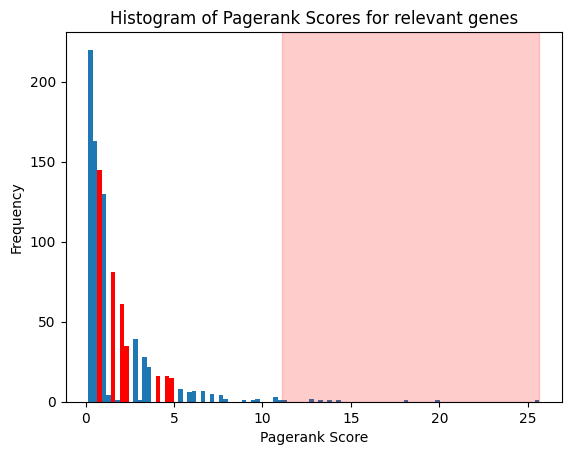

In [18]:
counts, bins, patches = plt.hist(df_pagerank_relevant["score"], bins=100)
plt.xlabel("Pagerank Score")
plt.ylabel("Frequency")
plt.title("Histogram of Pagerank Scores for relevant genes")

# highlight the top 10 genes
min = df_pagerank_relevant["score"].head(10).min()
max = df_pagerank_relevant["score"].head(10).max()
plt.axvspan(min, max, color='r', alpha=0.2)

highlight_values = df_known_genes["score"]
for value in highlight_values:
    for i in range(len(bins) - 1):
        if bins[i] <= value < bins[i + 1]:
            patches[i].set_facecolor('red')


plt.savefig('../tex/figures/05_01_pagerank_known_genes.png')
plt.show()

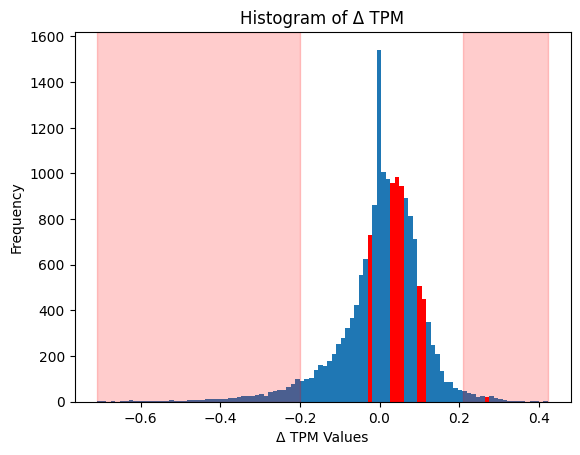

In [19]:
counts, bins, patches = plt.hist(df_nodes_genes['Δ TPM'], bins=100)
plt.title('Histogram of Δ TPM')
plt.xlabel('Δ TPM Values')
plt.ylabel('Frequency')

# highlight the relevant genes
plt.axvspan(min_delta, min_significant, color='r', alpha=0.2)
plt.axvspan(max_significant, max_delta, color='r', alpha=0.2)

# highlight the known genes
highlight_values = df_known_genes["Δ_TPM"]
for value in highlight_values:
    for i in range(len(bins) - 1):
        if bins[i] <= value < bins[i + 1]:
            patches[i].set_facecolor('red')


plt.savefig('../tex/figures/05_01_delta_tpm_relevant.png')
plt.show()